### Mixture of Experts (MoE) Transformer with Llama4 type model 

Author: Tirth Shah  
Inspired by: https://github.com/FareedKhan-dev/train-llama4

In this notebook, we perform inference with the trained model saved in saved_models directory. We also analyze the MoE layer in detail.

#### Import Required Libraries and Modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Import our custom modules
from model import MoETransformer, ModelConfig
from prepare_data import CharDataset, TinyStoriesDataset, sample_alice_text
from train import TrainModel
import utils

/home/tirth/miniforge-pypy3/envs/moe-experiments/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Select device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Load model

In [3]:
# Load the trained MoETransformer model
model_path = './saved_models/tiny_stories_random_routing_False_top_1.pth'

model, train_config, train_losses, routing_entropies, expert_utilizations = utils.load_model(model_path)
model.to(device)
model.eval()

# normalize expert_utilizations to probabilities
expert_utilizations = expert_utilizations / expert_utilizations.sum(axis=-1, keepdims=True)

Model loaded from ./saved_models/tiny_stories_random_routing_False_top_1.pth


In [4]:
# Get the dataset (and tokenizer) on which the model was trained

if model.config.dataset_tag == 'sample_alice':
    block_size = 64 # Define the block size for the dataset
    dataset = CharDataset(text=sample_alice_text, block_size=block_size) # Create dataset

elif model.config.dataset_tag == 'tiny_stories':
    block_size = 64 # Define the block size for the dataset
    dataset = TinyStoriesDataset(block_size=block_size, max_samples=100000)  # Load the dataset

else:
    raise ValueError("Invalid dataset_tag. Choose 'sample_alice' or 'tiny_stories'.")

TinyStoriesDataset loaded with 100000 stories and vocabulary size 17938


In [5]:
# Initialize the TrainModel class (useful for test-loss and top-5 accuracy calculation)

train_model = TrainModel(
    train_config=train_config,
    model=model,
    dataset=dataset,
)

#### Analyze

Generate sequence

In [6]:
if model.config.dataset_tag == 'sample_alice':
    seed_text = "Alice likes"
elif model.config.dataset_tag == 'tiny_stories':
    seed_text = "Once upon a time"

model.generate(
    seed_text=seed_text,
    tokenizer=dataset.tokenizer,
    max_new_tokens=model.config.block_size,
)

Generation loop finished.


"Once upon a time, there was a little girl named Lily. She loved to play in her backyard and make pictures of everything. One day, her mom told her that you lost her small hook. Lily was so happy and always carried it with her - it was empty.\n\nWhen she finished mum saw the volcano, Lily's mom"

Training loss

Final training loss: 2.441101551055908


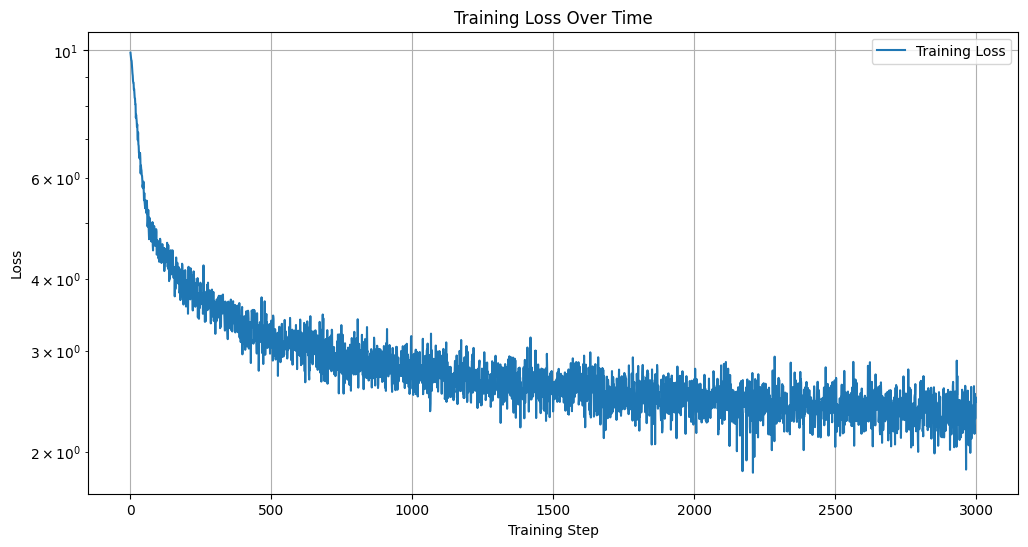

In [7]:
print(f"Final training loss: {train_losses[-1]}")

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

Test loss

In [8]:
test_loss = train_model.test_loss()

print(f"Test loss: {test_loss:.4f}")

Test loss: 2.3229


Top-k Accuracy

In [22]:
k = 1  # Top-k accuracy
top_k_accuracy = train_model.test_top_k_accuracy(k)

print(f"Top-{k} accuracy: {top_k_accuracy:.4f}")

Top-1 accuracy: 51.1045


Routing Entropies

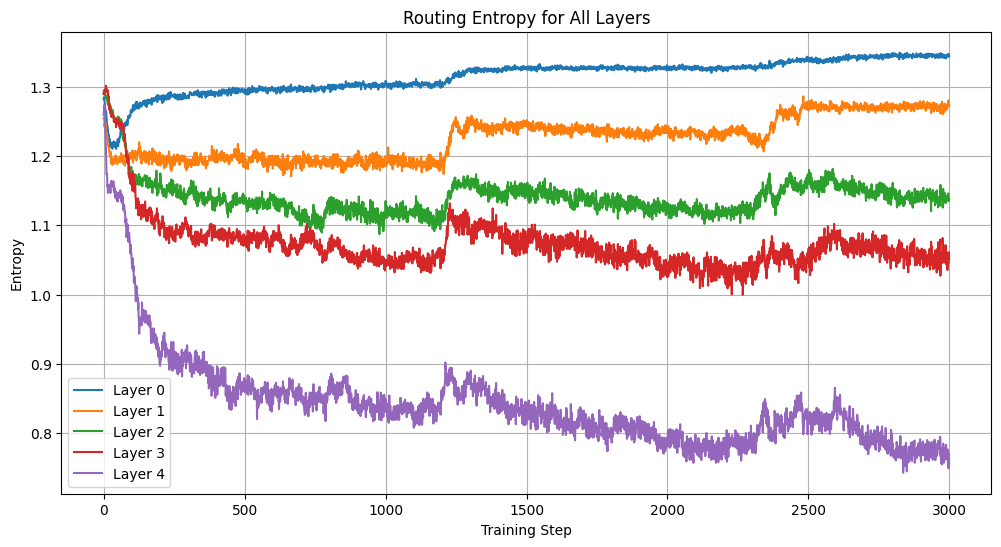

In [7]:
plt.figure(figsize=(12, 6))
for layer_idx in range(routing_entropies.shape[1]):
    plt.plot(routing_entropies[:, layer_idx], label=f'Layer {layer_idx}')
plt.title('Routing Entropy for All Layers')
plt.xlabel('Training Step')
plt.ylabel('Entropy')
plt.legend()
plt.grid()
plt.show()


Expert Utilizations

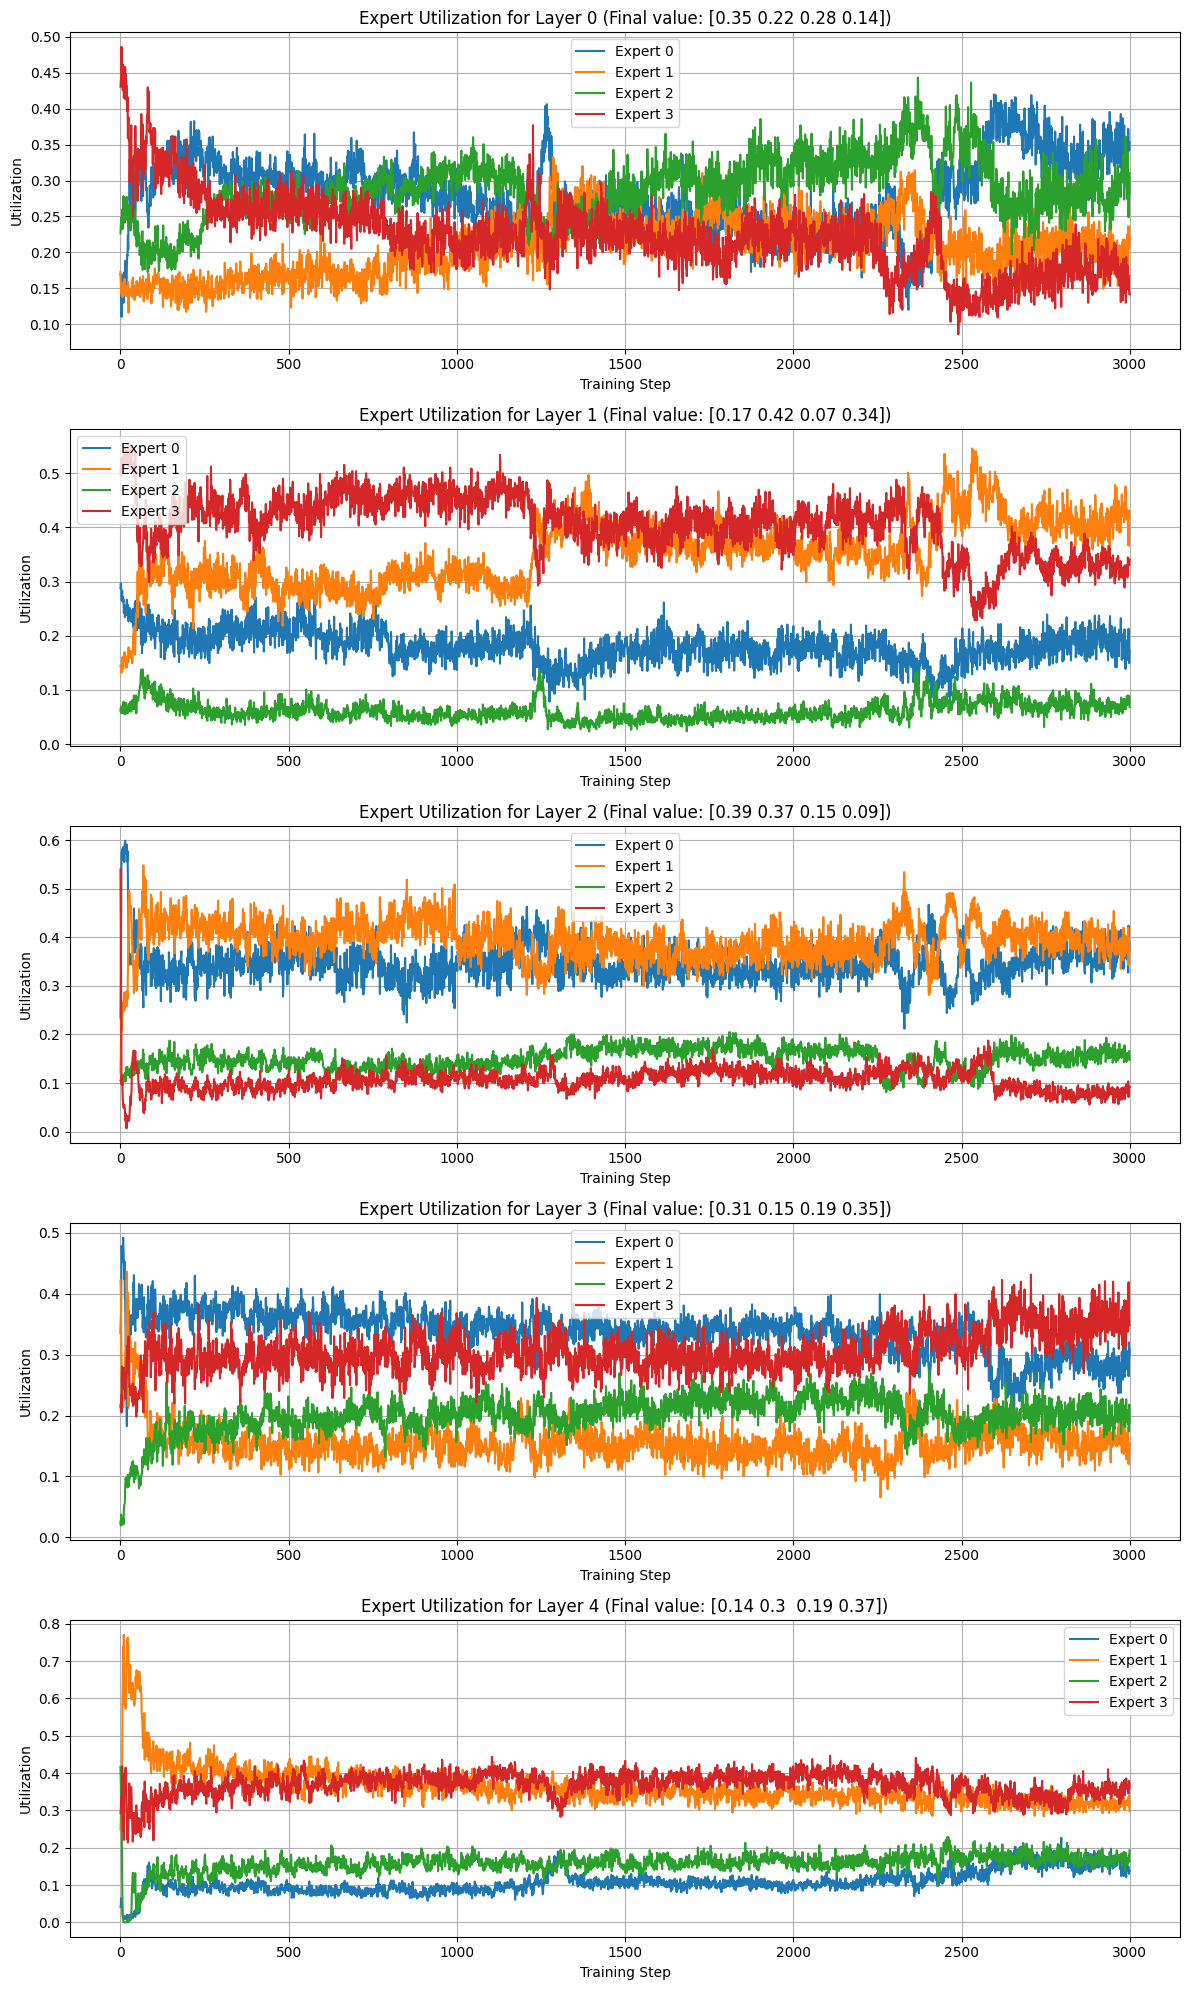

In [8]:
# Plot expert utilizations for all layers in subplots
fig, axes = plt.subplots(expert_utilizations.shape[1], 1, figsize=(12, 4 * expert_utilizations.shape[1]))

for layer_idx in range(expert_utilizations.shape[1]):
    ax = axes[layer_idx] if expert_utilizations.shape[1] > 1 else axes
    
    for expert_idx in range(expert_utilizations.shape[2]):
        ax.plot(expert_utilizations[:, layer_idx, expert_idx], label=f'Expert {expert_idx}')
    
    ax.set_title(f'Expert Utilization for Layer {layer_idx} (Final value: {np.round(expert_utilizations[-1, layer_idx, :], 2)})')
    ax.set_xlabel('Training Step')
    ax.set_ylabel('Utilization')
    ax.legend()
    ax.grid()

plt.tight_layout()
plt.show()

#### Additional code

In [9]:
print(f"Routing Entropy: {model.moe_layers[0].compute_routing_entropy()}")

print(f"Expert Utilization: {model.moe_layers[0].compute_expert_utilization()}")

Routing Entropy: 1.344390869140625
Expert Utilization: [29 19  7  9]
